In [28]:
try:
    from rich import load_ipython_extension
    %load_ext rich
except ImportError:
    try:
        from rich import pretty
        pretty.install()
    except ImportError:
        pass

The rich extension is already loaded. To reload it, use:
  %reload_ext rich


In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Using the cleaned dataset created in assignment 1

In [30]:
data = pd.read_csv("../data/manipulated_data.csv")
data

,sex,age,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
0,Man,16-19,TOT,2018,547.9,38091,Stockholm,primary/lower secondary
1,Man,16-19,0,2018,0.0,13357,Stockholm,primary/lower secondary
2,Man,16-19,1-19,2018,137.9,17417,Stockholm,primary/lower secondary
3,Man,16-19,20-39,2018,106.1,3763,Stockholm,primary/lower secondary
4,Man,16-19,40-59,2018,77.2,1574,Stockholm,primary/lower secondary
...,...,...,...,...,...,...,...,...
409255,Woman,65-69,80-99,2012,0.9,10,Norrbotten,unknown
409256,Woman,70-75,TOT,2012,2.4,36,Norrbotten,unknown
409257,Woman,70-75,0,2012,0.0,11,Norrbotten,unknown
409258,Woman,70-75,1-19,2012,0.1,6,Norrbotten,unknown


Checking data types

In [31]:
data.dtypes


sex                        object
age                        object
income_bracket             object
year                        int64
total_sum_sek_millions    float64
number_of_persons           int64
region_name                object
level_of_education         object
dtype: object

To set data types correctly for each column the function and type map from assignment 1 is used.

In [32]:
def convert_types(type_map, df):
    for item in type_map.items():
        if item[1] == "int64":
            df[item[0]] = pd.to_numeric(df[item[0]], errors="coerce").astype("Int64")
        elif item[1] == "float64":
            df[item[0]] = pd.to_numeric(df[item[0]], errors="coerce").astype("float64")
        elif item[1] == "string":
            df[item[0]] = df[item[0]].astype("string")

In [33]:
type_map_data = {
    "region_name": "string",
    "level_of_education": "string",
    "sex": "string",
    "age": "string",
    "income_bracket": "string",
    "year": "int64",
    "total_sum_sek_millions": "float64",
    "number_of_persons": "int64",
}

convert_types(type_map_data, data)
data.dtypes


sex                       string[python]
age                       string[python]
income_bracket            string[python]
year                               Int64
total_sum_sek_millions           float64
number_of_persons                  Int64
region_name               string[python]
level_of_education        string[python]
dtype: object

### MITT NYA ===================================================================



We wanted to find out if there are any variables that correlate with each other. When we analyzed this (see below), we found no strong correlations. The only meaningful one is between the total sum and the number of persons, which makes sense, more money should generally mean more people that are working.

To do this, the categorical variables need to be converted into numeric values

In [34]:
new_df = data.copy()

#converting categorical variables
new_df['sex'] = new_df['sex'].astype('category').cat.codes
new_df['age'] = new_df['age'].astype('category').cat.codes
new_df['income_bracket'] = new_df['income_bracket'].astype('category').cat.codes
new_df['region_name'] = new_df['region_name'].astype('category').cat.codes
new_df['level_of_education_num'] = new_df['level_of_education'].astype('category').cat.codes

#preform pairwise_corr 
corr_matrix = pg.pairwise_corr(new_df, method="pearson")

#sort the correlations to get the top 3 highest values (no self-correlation)
corr_values = corr_matrix[['X', 'Y', 'r']]

#sort by the correlation coefficient in descending order and get the top 3
top_3_corr = corr_values[corr_values['X'] != corr_values['Y']].sort_values(by='r', ascending=False).head(3)

print(top_3_corr)

                         X                       Y         r
22  total_sum_sek_millions       number_of_persons  0.916260
14          income_bracket  total_sum_sek_millions  0.109254
15          income_bracket       number_of_persons  0.105514


We tried to find a value that gives us better correlations. In the last assignment, we calculated average income. We reused that and ran it again, giving us a better correlation of 0.25 compared to the second best before, which was 0.1.

In [35]:
new_df["avg_income"] = new_df["total_sum_sek_millions"] * 1_000_000 / new_df["number_of_persons"]

#preform pairwise_corr 
corr_matrix = pg.pairwise_corr(new_df, method="pearson")

#sort the correlations to get the top 3 highest values (no self-correlation)
corr_values = corr_matrix[['X', 'Y', 'r']]

#sort by the correlation coefficient in descending order and get the top 3
top_3_corr = corr_values[corr_values['X'] != corr_values['Y']].sort_values(by='r', ascending=False).head(3)

print(top_3_corr)

                         X                       Y         r
26  total_sum_sek_millions       number_of_persons  0.916260
20          income_bracket              avg_income  0.252788
16          income_bracket  total_sum_sek_millions  0.109254


We tried to run an SVC with a linear kernel, but it took a very long time and did not yield any good results. Instead, we tried with an RBF kernel and got some good results. We looked at only 2 years to keep the runtime reasonable.

In [36]:
from sklearn.svm import SVC
new_df = new_df[new_df['year'] >= 2022]
X = new_df[["total_sum_sek_millions", "age", "sex", "avg_income"]] 
y = new_df["income_bracket"]

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train)


#train SVM
model = SVC(C=1.0, gamma=0.0001, kernel="rbf")

#fit model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

0.9120255693168198

Finding out what was important for the classification.

In [37]:
from sklearn.inspection import permutation_importance

pi = permutation_importance(model, X_test, y_test, n_repeats=3, random_state=0)
pi['importances_mean']


array([0.09260887, 0.        , 0.        , 0.85334931])

To make the results more readable, we print them with their name and value.

In [38]:
used_features = ["total_sum_sek_millions", "age", "sex", "avg_income"]

# Skapa DataFrame med importances
importance_df = pd.DataFrame({
    "feature": used_features,
    "importance_mean": pi['importances_mean'],
    "importance_std": pi['importances_std']
})

# Sortera snyggt
importance_df = importance_df.sort_values(by="importance_mean", ascending=False)

# Visa
print(importance_df)

                  feature  importance_mean  importance_std
3              avg_income         0.853349        0.001813
0  total_sum_sek_millions         0.092609        0.000598
1                     age         0.000000        0.000000
2                     sex         0.000000        0.000000


We perform PCA in 3 dimensions on data from 2023 and onward.
We do this in an exploratory search.

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

new_df = new_df.drop(columns=["level_of_education"])

#take only > 2023
X = new_df[new_df['year'] >= 2023]

#scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#preform pca
pca = PCA(n_components=3)
df_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(df_pca, columns=["PC1", "PC2", "PC3"])


df_pca["region_name"] = new_df.loc[X.index, "region_name"].values
df_pca = df_pca.set_index("region_name")



We plot the results in 3D to see the results more clearly.
We see that a lot of the points are tightly clustered together, and some branch off in another direction.
Looking at this, it makes sense that the linear SVM had a hard time.

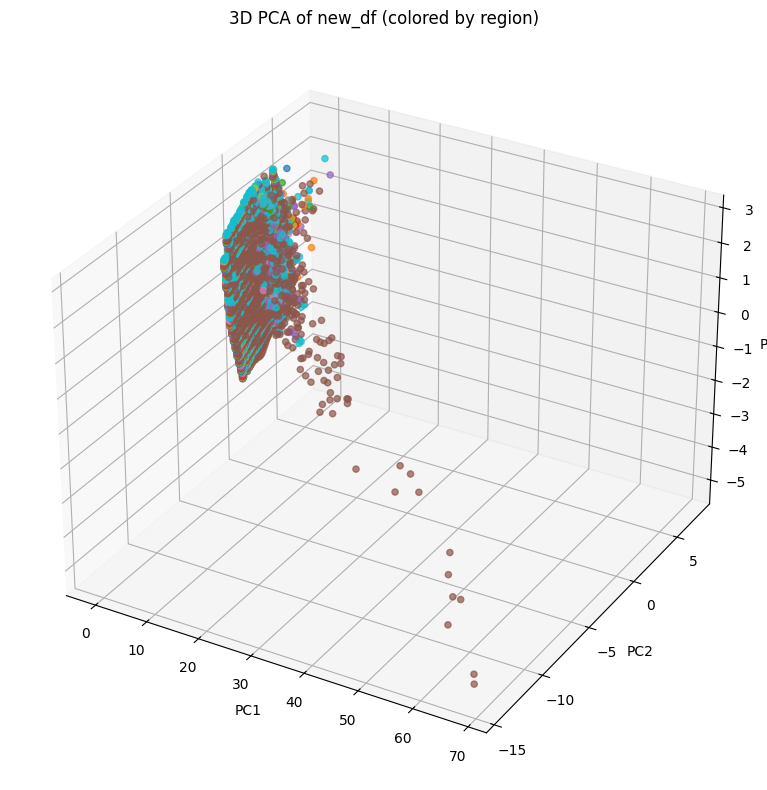

In [41]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_pca["PC1"],
    df_pca["PC2"],
    df_pca["PC3"],
    c=df_pca.index.astype(int),
    cmap='tab10',
    alpha=0.7
)


ax.set_title("3D PCA of new_df (colored by region)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.tight_layout()
plt.show()
